<a href="https://colab.research.google.com/github/JorgeTonatiuh/Tarea_1/blob/main/red_completamente_conectada_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Red completamente conectada con PyTorch

Implementa una red completamente conectada para la tarea de clasificación de imágenes sobre
el conjunto de Fashion-MNIST, tomando en cuenta las siguiente especificaciones:

*   Explora con diferentes número de neuronas, capas, funciones de activación e hiperparámetros.
*   Discute tus resultados con las distintas configuraciones.

In [1]:
# biblioteca para inspeccionar arquitecturas
# https://github.com/tyleryep/torchinfo
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import random
from itertools import islice as take

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as T

# Para procesamiento de imágenes
from skimage import io

from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
# inspección de arquitectura
from torchinfo import summary

from tqdm.auto import trange

# Utilería

Se definen funciones para imprimir las imagenes del dataset.

In [3]:
# directorio de datos
DATA_DIR = '../data'

# tamaño del lote
BATCH_SIZE = 32
# filas y columnas de la regilla de imágenes
ROWS, COLS = 4, 8


def display_grid(xs, titles, rows, cols, figsize=(12, 6)):
    """Displays examples in a grid."""
    fig, ax = plt.subplots(rows, cols, figsize=figsize)
    i = 0
    for r in range(rows):
        for c in range(cols):
            ax[r, c].imshow(xs[i], cmap='gray')
            ax[r, c].set_title(titles[i])
            ax[r, c].set_xticklabels([])
            ax[r, c].set_yticklabels([])
            i += 1
    fig.tight_layout()
    plt.show()


def display_batch(x, titles, rows, cols, figsize=(12, 6)):
    """Displays a batch of processed examples in a grid."""
    # denormalizamos [0, 1] => [0, 255]
    x *= 255
    # rotamos canales (C x H x W) => (H x W x C)
    x = x.permute(0, 2, 3, 1)
    # convertimos a entero
    x = (x.numpy()).astype(np.uint8)
    # aplanamos canal
    x = x.reshape(*x.shape[:3])
    # desplegamos
    display_grid(x, titles, rows, cols, figsize)

    
def set_seed(seed=0):
    """Initializes pseudo-random number generators."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    
# reproducibilidad
set_seed()

# Datos

## Explorción

PyTorch provee la clase FashionMNIST, una implementación de Dataset lista para usar del conjunto FashionMNIST.

Fashion-MNIST es un conjunto de datos de imágenes de artículos de Zalando que consta de un conjunto de entrenamiento de 60 000 ejemplos y un conjunto de prueba de 10 000 ejemplos. Cada ejemplo es una imagen en escala de grises de 28x28, asociada con una etiqueta de 10 clases.

Enseguida se definira un dataset para visualizar el contenido y las distintas clases.

In [4]:
# Se crea un dataset
ds = FashionMNIST(
    # directorio de datos
    root=DATA_DIR,
    # subconjunto de entrenamiento
    train=True,
    # convertir la imagen a ndarray
    transform=np.array,
    # descargar el conjunto
    download=True
)

Se imprimen unas imagenes para visualizar el contendio y las distintas clases.

A diferencia del dataset de los números MNIST, en este dataset son imagenes de ropa y cada tipo de prenda está representada por un número para diferenciar una clase de prenda de otra.

images[0] shape=(28, 28) dtype=uint8


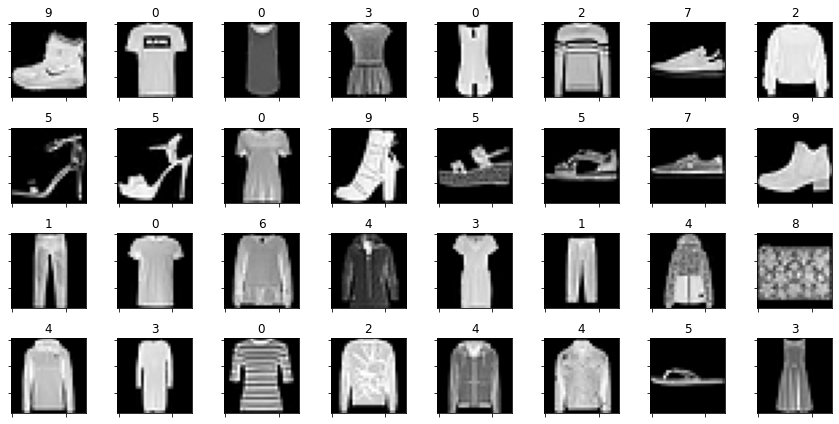

In [5]:
# cargamos algunas imágenes
images, labels = [], []
for i in range(BATCH_SIZE):
    x, y = ds[i]
    images.append(x)
    labels.append(y)

# desplegamos
print(f'images[0] shape={images[0].shape} dtype={images[0].dtype}')
titles = [str(y) for y in labels]
display_grid(images, titles, ROWS, COLS)

# Cargadores de datos

## Entrenamiento

Enseguida se definen el dataset y el dataloader que se usaran para entrenar el modelo.


x shape=torch.Size([32, 1, 28, 28]) dtype=torch.float32
y shape=torch.Size([32]) dtype=torch.int64


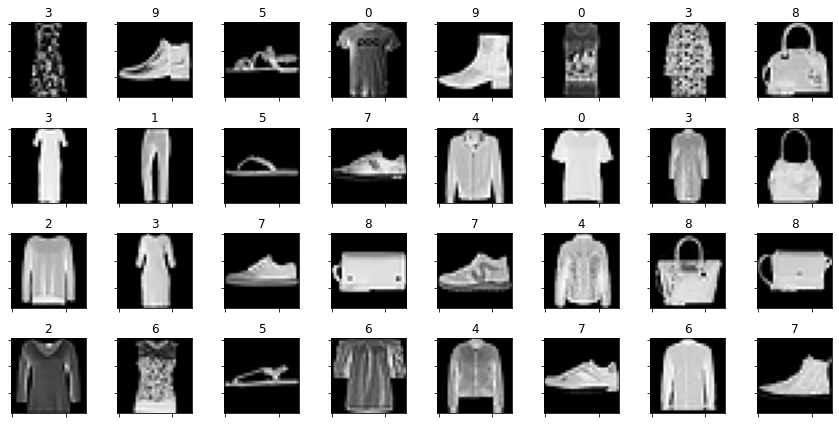

In [6]:
# transformación que convierte una imagen:
#   de numpy.ndarray    (H x W x C) en rango [0, 255]
#   a torch.FloatTensor (C x H x W) en rango [0, 1]
tsfm = T.ToTensor()

# creamos un Dataset
trn_ds = FashionMNIST(
    # directorio de datos
    root=DATA_DIR,
    # subconjunto de entrenamiento
    train=True,
    # transformación
    transform=tsfm
)

# creamos un DataLoader
trn_dl = DataLoader(
    # conjunto
    trn_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True
)

# desplegamos un lote de imágenes
x, y = next(iter(trn_dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
display_batch(x, y.tolist(), ROWS, COLS)

## Prueba

Enseguida se definen el dataset y el dataloader que se usaran para probar el modelo.

x shape=torch.Size([32, 1, 28, 28]) dtype=torch.float32
y shape=torch.Size([32]) dtype=torch.int64


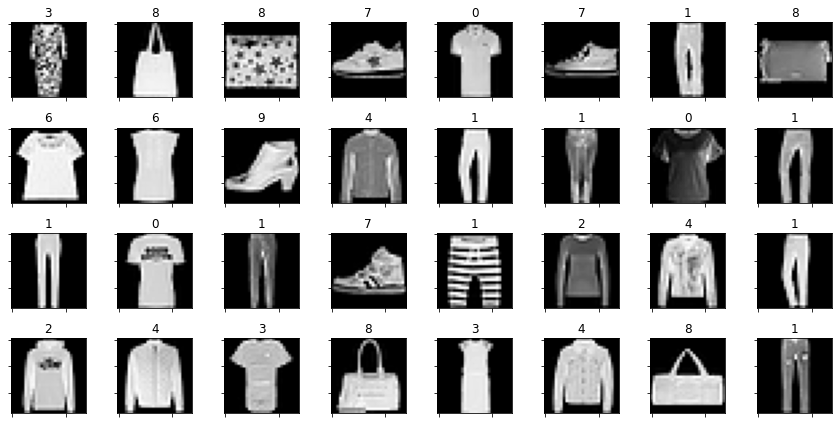

In [7]:
# creamos un Dataset
tst_ds = FashionMNIST(
    # directorio de datos
    root=DATA_DIR, 
    # subconjunto de entrenamiento
    train=False,
    # transformación
    transform=tsfm
)

# creamos un DataLoader
tst_dl = DataLoader(
    # subconjunto
    tst_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True
)

# desplegamos un lote de imágenes
x, y = next(iter(tst_dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
display_batch(x, y.tolist(), ROWS, COLS)

# Modelo

## Definición de la arquitectura

Arquitectura de la red completamente conectada.

Es una implementación en el que se utiliza la API de pytorch tanto de medio y alto nivel, se utiliza un sequential en el que se realizarán varias modificaciones para realizar las distintas configuraciones de red, Se utiliza un Flatten para aplanar la matriz de pixeles a un vector [N, 1, 28, 28] para usar en la red. 

El modelo que se muestra a continuación es una red completemente conectada, con una capa de entrada 4 capas ocultas y una de salida (784-128-156-156-128-10)


In [8]:
class FCN(nn.Module):

    # inicializador
    def __init__(self):

        # inicilización del objeto padre, obligatorio
        super().__init__()

        self.I = 1 * 28 * 28
        FC1, FC2 = 128, 10

        # definición de capas
        self.cls = nn.Sequential(
            # aplanamos la matriz de píxeles a un vector
            # [N, 1, 28, 28] => [N, 1x28x28]
            nn.Flatten(),
            # fc1
            # [N, 1x28x28] => [N, 128]
            nn.Linear(self.I, FC1),
            nn.ReLU(),

            nn.Linear(128, 156),
            nn.ReLU(),
            nn.Linear(156, 156),
            nn.ReLU(),
            nn.Linear(156, 128),
            nn.ReLU(),

            # fc2
            # [N, 128] => [N, 10]
            nn.Linear(FC1, FC2)
        )

    # método para inferencia
    def forward(self, x):
        # [N, 1x28x28]
        x = self.cls(x)
        return x

## Instancia de la arquitectura

A continuación se imprime la configuración del modelo.

In [9]:
model = FCN()
print(model)

FCN(
  (cls): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=156, bias=True)
    (4): ReLU()
    (5): Linear(in_features=156, out_features=156, bias=True)
    (6): ReLU()
    (7): Linear(in_features=156, out_features=128, bias=True)
    (8): ReLU()
    (9): Linear(in_features=128, out_features=10, bias=True)
  )
)


Para verificar que el modelo no contiene fallas de inconsistencia de algun tipo se realizará una inferencia con datos sintéticos.

In [10]:
# inferencia con datos sintéticos
x = torch.zeros(1, 1, 28, 28)
y = model(x)
print(f'{x.shape} => {y.shape}')

torch.Size([1, 1, 28, 28]) => torch.Size([1, 10])


## Inspección de la arquitectura

Con el somando summary se puede imprimir una inspección de la arquitectura para concer las funciones de activación que contiene así como las capas y el número de neuronas en cada capa.

In [11]:
summary(model, (1, 28, 28), 
        col_names=['input_size', 'output_size'],
        device='cpu', verbose=0)

Layer (type:depth-idx)                   Input Shape               Output Shape
FCN                                      [1, 28, 28]               [1, 10]
├─Sequential: 1-1                        [1, 28, 28]               [1, 10]
│    └─Flatten: 2-1                      [1, 28, 28]               [1, 784]
│    └─Linear: 2-2                       [1, 784]                  [1, 128]
│    └─ReLU: 2-3                         [1, 128]                  [1, 128]
│    └─Linear: 2-4                       [1, 128]                  [1, 156]
│    └─ReLU: 2-5                         [1, 156]                  [1, 156]
│    └─Linear: 2-6                       [1, 156]                  [1, 156]
│    └─ReLU: 2-7                         [1, 156]                  [1, 156]
│    └─Linear: 2-8                       [1, 156]                  [1, 128]
│    └─ReLU: 2-9                         [1, 128]                  [1, 128]
│    └─Linear: 2-10                      [1, 128]                  [1, 10]
Total param

# Entrenamiento

## Ciclo de entrenamiento

Las sigueintes funciones definen el ciclo de entrenamiento, y también algunos hyperparámetros como el número de épocas, la tasa de aprendizaje, función de pérdida, etc. 

In [12]:
# La siguiente función se utiliza para entrenar una epoca
# Parametros:
#   dl: dataloader
#   model: modelo a entrenar
#   opt: optimizador  
def train_epoch(dl, model, opt):

    # por cada lote
    for x, y_true in dl:
        
        # computamos logits
        y_lgts = model(x)
        
        # computamos la pérdida
        loss = F.cross_entropy(y_lgts, y_true)
        
        # vaciamos los gradientes
        opt.zero_grad()
        
        # retropropagamos
        loss.backward()
        
        # actualizamos parámetros
        opt.step()


# Esta función evalua la epoca, y regresa tanto 
# la perdida y la exactitud que se calcularon 
# durante el entrenamiento.
# Parametros:
#   dl: dataloader
#   model: modelo a entrenar
#   num_batches: numero de batches
# Regresa:
#   historial de perdida y exactitud     
def eval_epoch(dl, model, num_batches=None):

    # evitamos que se registren las operaciones 
    # en la gráfica de cómputo
    with torch.no_grad():

        # historiales
        losses, accs = [], []

        # validación de la época con num_batches
        # si num_batches==None, se usan todos los lotes
        for x, y_true in take(dl, num_batches):

            # computamos los logits
            y_lgts = model(x)

            # computamos los puntajes
            y_prob = F.softmax(y_lgts, 1)

            # computamos la clases
            y_pred = torch.argmax(y_prob, 1)

            # computamos la pérdida
            loss = F.cross_entropy(y_lgts, y_true)

            # computamos la exactitud
            acc = (y_true == y_pred).type(torch.float32).mean()

            # guardamos históricos
            losses.append(loss.item())
            accs.append(acc.item())

        # promediamos
        loss = np.mean(losses) * 100
        acc = np.mean(accs) * 100

        return loss, acc
        
        
# Esta función realiza el entrenamiento utilizando las 
# funciones anteriormente definidas, tanto para el 
# conjunto de entrenamiento como para el conjunto de prueba. 
# Parametros:
#   model: modelo a entrenar
#   trn_dl: dataloader de entrenamiento
#   tst_dl: dataloader de prueba
#   lr: tasa de aprendizaje
#   epochs: numero de epocas
# Regresa:
#   historial de perdida y exactitud     
def train(model, trn_dl, tst_dl, lr=1e-3, epochs=300,
          trn_batches=None, tst_batches=None):

    # historiales
    loss_hist, acc_hist = [], []
    
    # optimizador
    opt = optim.SGD(model.parameters(), lr=lr)

    # ciclo de entrenamiento
    for epoch in trange(epochs):

        # entrenamos la época
        train_epoch(trn_dl, model, opt)

        # evaluamos la época en entrenamiento
        trn_loss, trn_acc = eval_epoch(trn_dl, model, trn_batches)
        # evaluamos la época en prueba
        tst_loss, tst_acc = eval_epoch(tst_dl, model, tst_batches)

        # guardamos historial
        loss_hist.append([trn_loss, tst_loss])
        acc_hist.append([trn_acc, tst_acc])

        # imprimimos progreso
        print(f'E{epoch:02} '
              f'loss=[{trn_loss:6.2f},{tst_loss:6.2f}] '
              f'acc=[{trn_acc:5.2f},{tst_acc:5.2f}]')

    return loss_hist, acc_hist

Entrenamiento del modelo

Se instancia un modelo y se ejecuta el entrenamiento.

In [13]:
model = FCN()
loss_hist, acc_hist = train(model, trn_dl, tst_dl)

  0%|          | 0/300 [00:00<?, ?it/s]

E00 loss=[229.70,229.71] acc=[10.01,10.00]
E01 loss=[228.26,228.28] acc=[17.12,16.19]
E02 loss=[223.78,223.82] acc=[21.31,20.90]
E03 loss=[204.86,205.00] acc=[22.33,22.31]
E04 loss=[163.26,163.66] acc=[35.49,35.64]
E05 loss=[130.03,130.79] acc=[44.56,43.95]
E06 loss=[113.47,114.51] acc=[55.30,54.69]
E07 loss=[104.08,105.25] acc=[59.30,58.95]
E08 loss=[ 96.71, 97.97] acc=[62.00,61.64]
E09 loss=[ 89.70, 90.83] acc=[66.59,65.90]
E10 loss=[ 83.56, 84.99] acc=[68.88,68.62]
E11 loss=[ 80.74, 82.54] acc=[70.68,70.09]
E12 loss=[ 77.23, 78.74] acc=[71.66,71.26]
E13 loss=[ 74.74, 76.57] acc=[73.60,72.85]
E14 loss=[ 71.56, 73.22] acc=[73.91,73.34]
E15 loss=[ 69.15, 70.85] acc=[75.88,75.29]
E16 loss=[ 66.06, 68.00] acc=[76.39,76.00]
E17 loss=[ 63.88, 65.76] acc=[77.26,76.72]
E18 loss=[ 61.93, 64.07] acc=[78.20,77.87]
E19 loss=[ 60.42, 62.43] acc=[78.78,78.10]
E20 loss=[ 59.11, 61.19] acc=[79.34,78.54]
E21 loss=[ 61.65, 64.38] acc=[77.95,76.49]
E22 loss=[ 57.40, 59.82] acc=[79.94,79.16]
E23 loss=[ 

## Gráficas de pérdida y exactitud

La siguientes graficas muestran la perdida y la exactitud obtenida durante todas las epocas tanto para el conjunto de entrenamiento como para el de prueba, se puede observar que alrededor de la época 50 el modelo comienza a presentar ligeros problemas con la generalización, conforme pasan las épocas se puede ver como tanto la perdida como la exactitud de ambos conjuntos comienzan a separarse.   

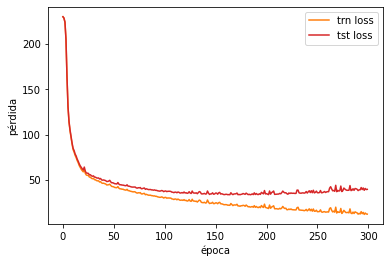

In [14]:
trn_loss, tst_loss = zip(*loss_hist)
plt.plot(trn_loss, 'tab:orange', label='trn loss')
plt.plot(tst_loss, 'tab:red', label='tst loss')
plt.legend(loc='upper right')
plt.xlabel('época')
plt.ylabel('pérdida')
plt.show()

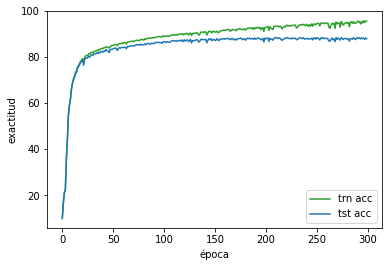

In [15]:
trn_acc, tst_acc = zip(*acc_hist)
plt.plot(trn_acc, 'tab:green', label='trn acc')
plt.plot(tst_acc, 'tab:blue', label='tst acc')
plt.legend(loc='lower right')
plt.xlabel('época')
plt.ylabel('exactitud')
plt.show()

# Evaluación

## Evaluación final

En seguida se muestra la evaluación final con el modelo que mejor resultados presentó, obteniendo una exactitud de 88 e el conjunto de prueba después de 300 épocas de entrenamiento.

Se colocó 300 épocas de entrenamiento para verificar si el modelo podía regresar un mejor resultado, pero el 88 en exactitud se obtuvo alrededor de la época 150, con este mismo modelo.

In [16]:
# evaluamos en entrenamiento
trn_loss, trn_acc = eval_epoch(trn_dl, model)
# evaluamos en prueba
tst_loss, tst_acc = eval_epoch(tst_dl, model)
print(f'loss=[{trn_loss:6.2f},{tst_loss:6.2f}] '
      f'acc=[{trn_acc:5.2f},{tst_acc:5.2f}]')

loss=[ 12.64, 39.87] acc=[95.68,88.01]


## Inferencia

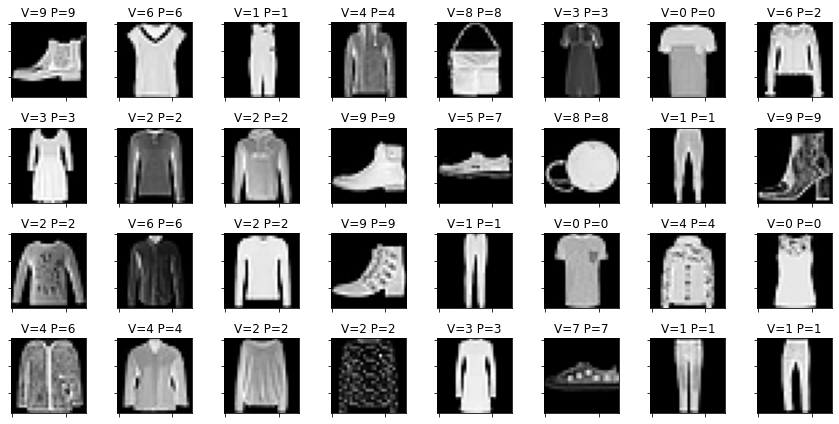

In [17]:
with torch.no_grad(): 
    x, y_true = next(iter(tst_dl))
    y_lgts = model(x)
    y_prob = F.softmax(y_lgts, 1)
    y_pred = torch.argmax(y_prob, 1)
    titles = [f'V={t} P={p}' for t, p in zip(y_true, y_pred)]
    display_batch(x, titles, ROWS, COLS)

# Pruebas

Se realizaron varias pruebas con distintas configuraciones de arquitectura, la presentada en el block es la que mejor desempeño presentó y es un buen resultado para este dataset, realizando una busqueda por internet, se encuentran algunas soluciones utilizando convolución con exactitud alrededor de 91. 

En seguida se muestran los resultados con diferentes configuraciones:

Red  | Perdida | Exactitud | epocas  | F. activación  |
-------------------|-----------------|----------------|-----|-----
748-128-256-128-10 | [ 43.60, 47.55] | [84.64,82.91]  | 20  | ReLU 
748-128-10         | [ 44.35, 47.61] | [84.78,83.51]  | 20  | ReLU
748-128-10         | [ 63.36, 65.04] | [77.64,76.74]  | 20  | Sigmoid
748-128-200-128-10 | [ 64.59, 66.82] | [77.00,75.97]  | 20  | Sigmoid-ReLU-ReLU
748-128-156-184-128-10 | [ 45.93, 49.63] | [84.04,82.43]  | 20  | ReLU
748-128-156-184-128-10 | [ 39.54, 43.91] | [86.17,84.66]  | 60  | ReLU
748-128-10  | [ 41.52, 45.23] | [85.77,84.07]  | 80  | ReLU
748-128-156-128-10  | [ 35.66, 40.57] | [87.56,85.87]  | 80  | ReLU
748-128-156-184-128-10  | [ 34.24, 39.79] | [87.81,85.79]  | 100 |ReLU
748-128-156-128-10  | [ 32.86, 38.36] | [88.53,86.48]  | 100  | ReLU
748-128-250-128-10  | [ 33.00, 38.59] | [88.53,86.56]  | 100  | ReLU
748-128-250-184-128-10  | [ 30.79, 37.70] | [89.02,86.82] | 100 | ReLU
748-128-156-184-212-184-156-128-10  | [ 32.77, 42.15] | [88.43,85.28] | 100 | ReLU
748-128-100-85-128-10  | [ 31.66, 38.93] | [88.55,86.03]  | 100  | ReLU
748-128-156-184-128-10  | [ 25.08, 35.75] | [90.95,87.51]  | 150 |ReLU
748-128-156-156-128-10  | [ 24.28, 34.67] | [91.25,87.81]  | 150  | ReLU
748-100-128-128-100-10  | [ 26.10, 35.61] | [90.62,87.33]  | 150  | ReLU
748-100-10  | [ 34.92, 39.98] | [87.96,86.09]   | 150  | ReLU
784-128-156-156-128-10 |[ 12.64, 39.87] | [95.68,88.01] | 300 | ReLU

Se realizaorn pruebas, aumentando el número de neuronas por capas, el número de capas, las funciones de pérdida, el número de épocas, diferentes valores de tasa de aprendizaje y los resultados mas aceptables obtenidos estan en la tabla anterior, los que no se agregaron dieron resultados en exactitud muy bajos o de plano el modelo no aprendía conforme pasaban las épocas, eso pasó mucho cuadno se utilizaba alguna función de périda distinta.

Ejecutando las diferentes pruebas noté que un número de 2 o 3 capas podía regresar valores de exactitud buenos (alrededor de 86) con un número de neuronas entre 100 y 160 (si aumentaba el número de neurnas de estos valores la exactitud disminuía). Pero el modelo que mejor resultados regresó fué el que se enlista al final de la tabla con 4 capas ocultas igualmente con un número de neuronas entre 100 y 160, con un total de 300 épocas de entrenamiento, aunque como ya se mencionó anteriormente el 88 en exactitud se obtuvo desde la época 150, pero se entrenó mas tiempo por si se presentaba una mejoría, pero después de la época 150 el modelo solo osciló entre 87 y 88 de exactitud en el conjunto de prueba. Al igual que con el núemro de neuronas por capa, también cuando se incrementaba el núemro de capas ocultas a un valor mayor a 4 el modelo ya no mejoraba, al contrario la exactitud bajaba.


Considero que es un valor aceptable ya que en realizando busquedas en internet de la solución a este conjunto de datos, se pueden observar soluciones de redes convolucionales con una exactitud de 91.6 u otros modelos mas complejos con exactitud de 96 (https://paperswithcode.com/sota/image-classification-on-fashion-mnist).